# Capstone Project: Airbnb Prediciting Prices 
____

In [268]:
# Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import RidgeCV, Ridge
from sklearn.linear_model import Lasso, LassoCV
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import ElasticNetCV

from sklearn import metrics
from sklearn.metrics import r2_score

from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from tensorflow.keras.layers import Dense, Dropout, Input

from sklearn.model_selection import cross_val_predict, cross_val_score

import pickle

In [269]:
# Reading dataset
listing = pd.read_csv('../data/listings_model.csv')

In [270]:
listing.columns

Index(['host_is_superhost', 'host_verifications', 'host_has_profile_pic',
       'host_identity_verified', 'neighbourhood_cleansed',
       'neighbourhood_group_cleansed', 'latitude', 'longitude', 'room_type',
       'accommodates', 'bedrooms', 'beds', 'price', 'minimum_nights',
       'maximum_nights', 'number_of_reviews', 'review_scores_rating',
       'instant_bookable', 'bathrooms_type', 'bathrooms_nbr',
       'neigh_price_sqft', 'description_count', 'description_words'],
      dtype='object')

# 3. Pre-Processing Data 
____

Check Distribution Data 
Check Outliers
Visualizations:
    - Barcharts by accomodation type
    - Scatter plot price acomodation (type accomodation legend) (?)
    - Map location lat/log (Folium) (?)
    - Time/price (?)     


In [271]:
listing.shape

(22183, 23)

In [272]:
listing['room_type'].value_counts()

Entire home/apt    11942
Private room        9843
Shared room          336
Hotel room            62
Name: room_type, dtype: int64

In [273]:
listing[listing['room_type']=='Private room'].loc[0]

host_is_superhost                                                               0
host_verifications                                             ['email', 'phone']
host_has_profile_pic                                                            1
host_identity_verified                                                          1
neighbourhood_cleansed                                                 kensington
neighbourhood_group_cleansed                                             Brooklyn
latitude                                                                 40.64529
longitude                                                               -73.97238
room_type                                                            Private room
accommodates                                                                    2
bedrooms                                                                      1.0
beds                                                                          1.0
price           

In [274]:
df  = listing.copy()
# Running model only on Private room
#df = listing[listing['room_type']=='Private room']

In [275]:
df.columns

Index(['host_is_superhost', 'host_verifications', 'host_has_profile_pic',
       'host_identity_verified', 'neighbourhood_cleansed',
       'neighbourhood_group_cleansed', 'latitude', 'longitude', 'room_type',
       'accommodates', 'bedrooms', 'beds', 'price', 'minimum_nights',
       'maximum_nights', 'number_of_reviews', 'review_scores_rating',
       'instant_bookable', 'bathrooms_type', 'bathrooms_nbr',
       'neigh_price_sqft', 'description_count', 'description_words'],
      dtype='object')

In [276]:
df.drop( columns=['host_verifications', 'neighbourhood_group_cleansed',
                'latitude', 'longitude', 'description_words', 'description_count','number_of_reviews'], 
         inplace=True)

In [277]:
df.columns

Index(['host_is_superhost', 'host_identity_verified', 'neighbourhood_cleansed',
       'room_type', 'accommodates', 'bedrooms', 'beds', 'price',
       'maximum_nights', 'review_scores_rating', 'instant_bookable',
       'bathrooms_type', 'bathrooms_nbr', 'neigh_price_sqft'],
      dtype='object')

In [278]:
df.head()

,host_is_superhost,host_identity_verified,neighbourhood_cleansed,room_type,accommodates,bedrooms,beds,price,maximum_nights,review_scores_rating,instant_bookable,bathrooms_type,bathrooms_nbr,neigh_price_sqft
0,0,1,kensington,Private room,2,1.0,1.0,299.0,730,4.89,0,shared,1.0,2.77
1,1,1,bedford-stuyvesant,Private room,2,1.0,1.0,60.0,730,4.52,0,private,0.0,2.83
2,0,1,sunset park,Entire home/apt,4,2.0,2.0,275.0,1125,5.00,0,private,1.5,2.31
3,1,1,greenpoint,Hotel room,2,1.0,1.0,308.0,365,4.90,0,private,1.0,3.83
4,0,1,east village,Private room,2,1.0,2.0,55.0,60,4.34,0,shared,1.5,5.71


In [279]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22183 entries, 0 to 22182
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   host_is_superhost       22183 non-null  int64  
 1   host_identity_verified  22183 non-null  int64  
 2   neighbourhood_cleansed  22183 non-null  object 
 3   room_type               22183 non-null  object 
 4   accommodates            22183 non-null  int64  
 5   bedrooms                22183 non-null  float64
 6   beds                    22183 non-null  float64
 7   price                   22183 non-null  float64
 8   maximum_nights          22183 non-null  int64  
 9   review_scores_rating    22183 non-null  float64
 10  instant_bookable        22183 non-null  int64  
 11  bathrooms_type          22183 non-null  object 
 12  bathrooms_nbr           22183 non-null  float64
 13  neigh_price_sqft        22183 non-null  float64
dtypes: float64(6), int64(5), object(3)
mem

## 3.1. Dummifying

In [280]:
df.columns

Index(['host_is_superhost', 'host_identity_verified', 'neighbourhood_cleansed',
       'room_type', 'accommodates', 'bedrooms', 'beds', 'price',
       'maximum_nights', 'review_scores_rating', 'instant_bookable',
       'bathrooms_type', 'bathrooms_nbr', 'neigh_price_sqft'],
      dtype='object')

In [281]:
# Setting category columns to Dummify
col_dummies = ['neighbourhood_cleansed', 'bathrooms_type', 'room_type'] #'neighbourhood_group_cleansed',

In [282]:
df.shape

(22183, 14)

In [283]:
df = pd.get_dummies(df, prefix_sep="__", columns = col_dummies, drop_first = True);

In [284]:
df.shape

(22183, 168)

In [285]:
#df.to_csv('../data/listing_preprocess.csv', index=False)

## 3.2. Creating X and y 

In [286]:
X = df.drop(columns='price')
y = np.log(df['price'])
print(X.shape)
print(y.shape)

(22183, 167)
(22183,)


In [287]:
X_train, X_test, y_train, y_test = train_test_split(
        X,  
        y,
        test_size = 0.3,     
        random_state = 42
 )

In [288]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((15528, 167), (6655, 167), (15528,), (6655,))

## 3.3. Scaling Data

In [289]:
sc = StandardScaler()
X_train_sc = sc.fit_transform(X_train)
X_test_sc = sc.transform(X_test)

# 4. Machine Learning Models
____

## 4.1. Baseline Model

In [237]:
#Setting a Baseline and getting its Score
baseline_model = [y_train.mean()] * len(y_test)
r2_score(y_test, baseline_model)

-0.00019758509399592228

### Fitting Regression Model
___

In [238]:
#Fitting Model
lr = LinearRegression()
lr.fit(X_train_sc, y_train)

LinearRegression()

In [239]:
#Cross Vaditadion Score
cross_val_score(lr, X_train_sc, y_train, cv=5).mean()
# -3.3924557963554062e+25

-1.7193767073982712e+26

In [240]:
# Calcuate residual
lr_y_preds = np.exp(lr.predict(X_train_sc))
residuals = y_train - lr_y_preds

# Metrics
print(f'MAE: {metrics.mean_absolute_error(y_train, lr_y_preds)}')
print(f'MSE: {metrics.mean_squared_error(y_train, lr_y_preds)}')
print(f'RMSE: {metrics.mean_squared_error(y_train, lr_y_preds, squared = False)}')
print(f'R2: {metrics.r2_score(y_train, lr_y_preds)}')
#MAE: 129.81014920371308
#MSE: 21210.975157781893
#RMSE: 145.63988175558882
#R2: -55534.009329901186

MAE: 129.55793290305587
MSE: 21169.037838764456
RMSE: 145.4958344378438
R2: -55259.33324890884


In [241]:
#Comparing scores
print(f'Train set: {lr.score(X_train_sc, y_train)}')
print(f'Test set: {lr.score(X_test_sc, y_test)}')
print(f'Diference (train/test): {lr.score(X_train_sc, y_train)-lr.score(X_test_sc, y_test)}')

#Train set: 0.6306346195368164
#Test set: -3.790486871672232e+20
#Diference (train/test): 3.790486871672232e+20


Train set: 0.6220602447465137
Test set: -1.8979655731841566e+21
Diference (train/test): 1.8979655731841566e+21


In [73]:
# Creating a list of coeficients
list_coef = list(zip( lr.coef_, X.columns))

In [74]:
# Turn it into a data frame
pd.DataFrame(lr.coef_, index = X.columns, columns = ['Coefficient'])

,Coefficient
host_is_superhost,5.952493e-02
host_has_profile_pic,-1.183742e-02
host_identity_verified,1.141846e-02
accommodates,1.610858e-01
beds,2.272259e-02
...,...
neighbourhood_cleansed__woodside,-1.387390e+10
bathrooms_type__shared,-8.118214e-02
room_type__Hotel room,1.572788e-02
room_type__Private room,-2.009679e-01


### Residuals
___

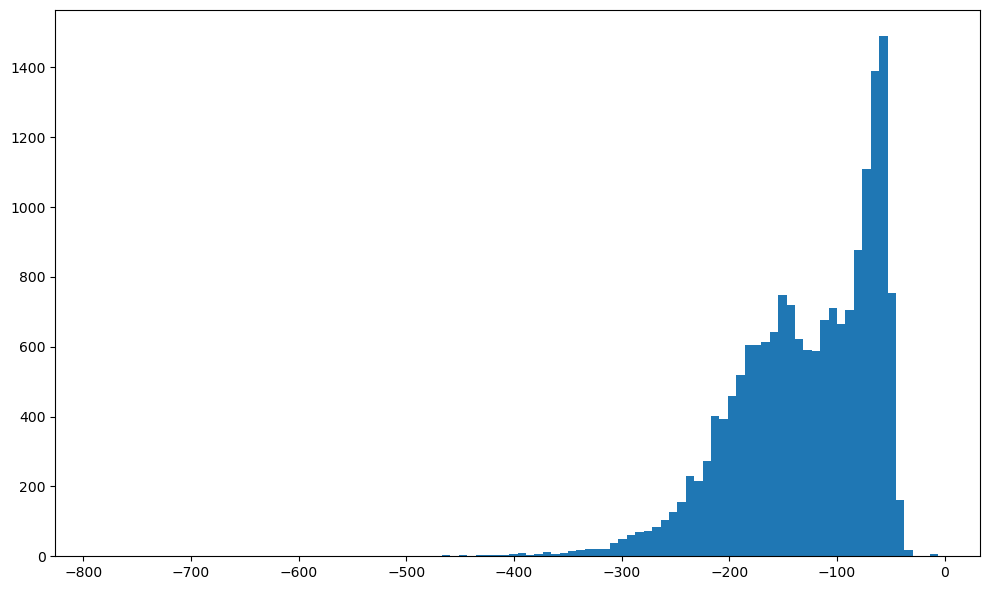

In [75]:
# Normality assumption 
plt.figure(figsize = (10, 6))
plt.hist(residuals, bins = 100);
plt.tight_layout()

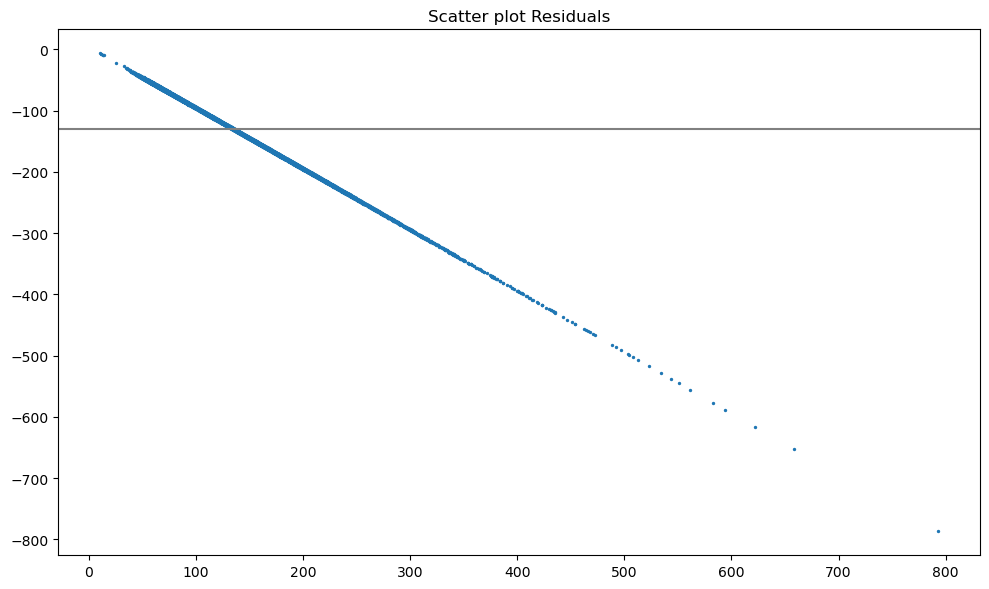

In [76]:
# Normality assumption 
plt.figure(figsize = (10,6))
plt.title("Scatter plot Residuals")
#Ploting Residuals - Scatter Plotf SLR Model 
plt.scatter(lr_y_preds, residuals,s=2);
plt.axhline(residuals.mean(), color='grey');
plt.tight_layout()

## 4.2. Lasso Regularization

In [290]:
# Set up a list of Lasso alphas to check.
l_alphas = np.logspace(-3, 0, 100)

# Cross-validate over our list of Lasso alphas.
lasso_cv = LassoCV(alphas=l_alphas)

# Fit model using best ridge alpha!
lasso_cv.fit(X_train_sc, y_train)

LassoCV(alphas=array([0.001     , 0.00107227, 0.00114976, 0.00123285, 0.00132194,
       0.00141747, 0.00151991, 0.00162975, 0.00174753, 0.00187382,
       0.00200923, 0.00215443, 0.00231013, 0.00247708, 0.00265609,
       0.00284804, 0.00305386, 0.00327455, 0.00351119, 0.00376494,
       0.00403702, 0.00432876, 0.00464159, 0.00497702, 0.0053367 ,
       0.00572237, 0.00613591, 0.00657933, 0.0070548 , 0.00756463,
       0.008...
       0.09326033, 0.1       , 0.10722672, 0.1149757 , 0.12328467,
       0.13219411, 0.14174742, 0.15199111, 0.16297508, 0.17475284,
       0.18738174, 0.2009233 , 0.21544347, 0.23101297, 0.24770764,
       0.26560878, 0.28480359, 0.30538555, 0.32745492, 0.35111917,
       0.37649358, 0.40370173, 0.43287613, 0.46415888, 0.49770236,
       0.53366992, 0.57223677, 0.61359073, 0.65793322, 0.70548023,
       0.75646333, 0.81113083, 0.869749  , 0.93260335, 1.        ]))

In [291]:
# Here is the optimal value of alpha
print("Best Value of alpha: ",lasso_cv.alpha_)

# Scores on Train a
print("Lasson Train Score: ", lasso_cv.score(X_train_sc, y_train))
print("Lasso Test Score", lasso_cv.score(X_test_sc, y_test))

Best Value of alpha:  0.002009233002565048
Lasson Train Score:  0.6207020424806944
Lasso Test Score 0.6123627344013678


In [292]:
# Calcuate residual
lasso_y_preds = np.exp(lasso_cv.predict(X_train_sc))
residuals = y_train - lasso_y_preds

# Metrics
print(f'MAE: {metrics.mean_absolute_error(y_train, lasso_y_preds)}')
print(f'MSE: {metrics.mean_squared_error(y_train, lasso_y_preds)}')
print(f'RMSE: {metrics.mean_squared_error(y_train, lasso_y_preds, squared = False)}')
print(f'R2: {metrics.r2_score(y_train, lasso_y_preds)}')

MAE: 129.10012903688164
MSE: 20850.05720035158
RMSE: 144.39548885041935
R2: -54426.65599107113


## 4.3. Ridge Regularization

In [80]:
# Instantiate.
ridge = Ridge(alpha = 100)

# Fit.
ridge.fit(X_train_sc, y_train)

# Evaluate model using R2.
print(f'Training Score: {ridge.score(X_train_sc, y_train)}')
print(f'Testing Score: {ridge.score(X_test_sc, y_test)}')

Training Score: 0.6265430762412164
Testing Score: 0.6170943481265876


In [81]:
# Calcuate residual
ridge_y_preds = np.exp(ridge.predict(X_train_sc))
residuals = y_train - ridge_y_preds

# Metrics
print(f'MAE: {metrics.mean_absolute_error(y_train, ridge_y_preds)}')
print(f'MSE: {metrics.mean_squared_error(y_train, ridge_y_preds)}')
print(f'RMSE: {metrics.mean_squared_error(y_train, ridge_y_preds, squared = False)}')
print(f'R2: {metrics.r2_score(y_train, ridge_y_preds)}')

MAE: 129.49883481282276
MSE: 21011.050393656493
RMSE: 144.95188992785327
R2: -55010.5622201671


## 4.4. KNNeighbors Regressor


In [82]:
knn_params = {
    'n_neighbors': [3, 5, 7, 9, 11, 13, 15],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'p': [1, 2]
}

# define the grid search
knn_grid= GridSearchCV(KNeighborsRegressor(), param_grid=knn_params, cv=5, verbose = -1)
knn_grid.fit(X_train_sc, y_train)

GridSearchCV(cv=5, estimator=KNeighborsRegressor(),
             param_grid={'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
                         'n_neighbors': [3, 5, 7, 9, 11, 13, 15], 'p': [1, 2]},
             verbose=-1)

In [83]:
knn_grid.best_params_

{'algorithm': 'kd_tree', 'n_neighbors': 9, 'p': 1}

In [84]:
print(f'Training Score: {knn_grid.score(X_train_sc, y_train)}')
print(f'Testing Score: {knn_grid.score(X_test_sc, y_test)}')

# Calcuate residual
knn_grid_y_preds = np.exp(knn_grid.best_estimator_.predict(X_train_sc))
residuals = y_train - knn_grid_y_preds

# Metrics
print(f'MAE: {metrics.mean_absolute_error(y_train, knn_grid_y_preds)}')
print(f'MSE: {metrics.mean_squared_error(y_train, knn_grid_y_preds)}')
print(f'RMSE: {metrics.mean_squared_error(y_train, knn_grid_y_preds, squared = False)}')
print(f'R2: {metrics.r2_score(y_train, knn_grid_y_preds)}')

Training Score: 0.7016913948055634
Testing Score: 0.6274875059575957
MAE: 129.53173027621844
MSE: 21055.74726088134
RMSE: 145.1059863027068
R2: -55127.58847284453


In [293]:
knn = KNeighborsRegressor(n_neighbors=5, p=2)
knn.fit(X_train_sc, y_train)

print(f'Training Score: {knn.score(X_train_sc, y_train)}')
print(f'Testing Score: {knn.score(X_test_sc, y_test)}')

# Calcuate residual
knn_y_preds = np.exp(knn.predict(X_train_sc))
residuals = y_train - knn_y_preds

# Metrics
print(f'MAE: {metrics.mean_absolute_error(y_train, knn_y_preds)}')
print(f'MSE: {metrics.mean_squared_error(y_train, knn_y_preds)}')
print(f'RMSE: {metrics.mean_squared_error(y_train, knn_y_preds, squared = False)}')
print(f'R2: {metrics.r2_score(y_train, knn_y_preds)}')

Training Score: 0.7236426470070934
Testing Score: 0.5819771660114312
MAE: 130.76471417814113
MSE: 21857.101984775923
RMSE: 147.84147586105843
R2: -57055.47789633316


## 4.5. CART 

In [86]:
# Instantiate model with:
# - a maximum depth of .
# - at least  samples required in order to split an internal node.
# - at least  samples in each leaf node.
# - a cost complexity of 0.01.
# - random state of 42.

dt_params = {
    'max_depth': [2, 3, 5, 7],
    'min_samples_split': [5, 10, 15, 20],
    'min_samples_leaf': [2, 3, 4, 5, 6],
    'ccp_alpha': [0.001, 0.01, 0.1, 1, 10]
}

dt_grid = GridSearchCV(
                    estimator = DecisionTreeRegressor(random_state=42),
                    param_grid = dt_params,
                    cv = 5,
                    verbose = 1)

# GridSearch!
dt_grid.fit(X_train_sc, y_train)

# What is our best decision tree?
print("Best Estimator: ", dt_grid.best_estimator_)

# What was the cross-validated score of the above decision tree?
print("Best Score: ", dt_grid.best_score_)

# Evaluate model.
print(f'Score on training set: {dt_grid.score(X_train_sc, y_train)}')
print(f'Score on testing set: {dt_grid.score(X_test_sc, y_test)}')


Fitting 5 folds for each of 400 candidates, totalling 2000 fits
Best Estimator:  DecisionTreeRegressor(ccp_alpha=0.001, max_depth=7, min_samples_leaf=2,
                      min_samples_split=5, random_state=42)
Best Score:  0.6062509736966872
Score on training set: 0.6116594478353327
Score on testing set: 0.5991781783755684


In [87]:
# Calcuate residual
dt_y_preds = np.exp(dt_grid.best_estimator_.predict(X_train_sc))
residuals = y_train - dt_y_preds

# Metrics
print(f'MAE: {metrics.mean_absolute_error(y_train, dt_y_preds)}')
print(f'MSE: {metrics.mean_squared_error(y_train, dt_y_preds)}')
print(f'RMSE: {metrics.mean_squared_error(y_train, dt_y_preds, squared = False)}')
print(f'R2: {metrics.r2_score(y_train, dt_y_preds)}')

MAE: 128.8427936984582
MSE: 20309.746911595197
RMSE: 142.5122693370476
R2: -53174.39508830954


## 4.6. Random Forest

In [294]:
# Taking 47 min to run
# Gridsearch Parameters
rf_params = {
    'n_estimators': [200, 250, 300, 400],
    'min_samples_leaf': [2, 3, 4, 5],
    'max_depth' : [None, 3, 4, 5, 6],
    'n_jobs': [-1]
}
# Setting Gridsearch
rf_grid = GridSearchCV(
    estimator = RandomForestRegressor(), 
    param_grid = rf_params, 
    cv = 5
)
# Fitting Model
rf_grid.fit(X_train_sc, y_train)

# Printing Outputs
print(f'Best Score : {rf_grid.best_score_}')
print(f'Best Parameters: {rf_grid.best_params_}') 
print(f'Score on training set: {rf_grid.score(X_train_sc, y_train)}')
print(f'Score on test set: {rf_grid.score(X_test_sc, y_test)}')

Best Score : 0.6559673619771015
Best Parameters: {'max_depth': None, 'min_samples_leaf': 5, 'n_estimators': 250, 'n_jobs': -1}
Score on training set: 0.7895183561550734
Score on test set: 0.6513888933524506


In [89]:
# Calcuate residual
rf_y_preds = np.exp(rf_grid.best_estimator_.predict(X_train_sc))
residuals = y_train - rf_y_preds

# Metrics
print(f'MAE: {metrics.mean_absolute_error(y_train, rf_y_preds)}')
print(f'MSE: {metrics.mean_squared_error(y_train, rf_y_preds)}')
print(f'RMSE: {metrics.mean_squared_error(y_train, rf_y_preds, squared = False)}')
print(f'R2: {metrics.r2_score(y_train, rf_y_preds)}')

MAE: 131.92502630313797
MSE: 22256.245304257445
RMSE: 149.18527174040153
R2: -58270.757023252285


## 4.7. Neural Network

In [90]:
def model_fn(h1_neurons = 32, h2_neurons=32, drop = 0.5):
  
  print(f'h1: {h1_neurons}, h2: {h2_neurons}, drop: {drop}')
  
  inputs = Input(shape = (X_train_sc.shape[1],))
  
  h1 = Dense(h1_neurons, activation = 'relu')(inputs)
  d1 = Dropout(drop)(h1)
  
  h2 = Dense(h2_neurons, activation = 'relu')(d1)
  out = Dense(1, activation = None)(h2)

  model = Model(inputs = inputs, outputs = out)

  model.compile(loss = 'mse',
                optimizer = 'adam', 
                metrics='acc')
  
  return model

In [91]:
# kind of like when lr = LinearRegression()
nn = KerasRegressor(build_fn = model_fn, batch_size = 256, verbose = 0)

In [92]:
params = {
    'epochs': [100],
    'h1_neurons': [16, 64, 128],
    'h2_neurons': [64, 128],
    'drop':[0.1,0.25, 0.5]
}

In [93]:
# 19 min to run
nn_grid = GridSearchCV(nn, param_grid = params, cv = 3)
nn_grid.fit(X_train_sc, y_train)

h1: 16, h2: 64, drop: 0.1


2022-11-13 00:26:43.792504: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-11-13 00:27:03.133336: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


h1: 16, h2: 64, drop: 0.1


2022-11-13 00:27:03.557066: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-11-13 00:27:22.530168: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


h1: 16, h2: 64, drop: 0.1


2022-11-13 00:27:22.800389: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-11-13 00:27:41.875851: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


h1: 16, h2: 128, drop: 0.1


2022-11-13 00:27:42.156960: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-11-13 00:28:01.284983: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


h1: 16, h2: 128, drop: 0.1


2022-11-13 00:28:01.569625: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-11-13 00:28:20.445206: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


h1: 16, h2: 128, drop: 0.1


2022-11-13 00:28:20.716476: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-11-13 00:28:39.662014: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


h1: 64, h2: 64, drop: 0.1


2022-11-13 00:28:39.940308: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-11-13 00:28:59.098219: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


h1: 64, h2: 64, drop: 0.1


2022-11-13 00:28:59.372358: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-11-13 00:29:18.507193: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


h1: 64, h2: 64, drop: 0.1


2022-11-13 00:29:18.786037: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-11-13 00:29:37.777287: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


h1: 64, h2: 128, drop: 0.1


2022-11-13 00:29:38.046375: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-11-13 00:29:57.209633: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


h1: 64, h2: 128, drop: 0.1


2022-11-13 00:29:57.480549: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-11-13 00:30:16.923346: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


h1: 64, h2: 128, drop: 0.1


2022-11-13 00:30:17.193880: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-11-13 00:30:36.128248: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


h1: 128, h2: 64, drop: 0.1


2022-11-13 00:30:36.701794: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-11-13 00:30:56.460063: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


h1: 128, h2: 64, drop: 0.1


2022-11-13 00:30:56.736482: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-11-13 00:31:15.835311: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


h1: 128, h2: 64, drop: 0.1


2022-11-13 00:31:16.104654: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-11-13 00:31:35.392972: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


h1: 128, h2: 128, drop: 0.1


2022-11-13 00:31:35.661876: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-11-13 00:31:54.849495: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


h1: 128, h2: 128, drop: 0.1


2022-11-13 00:31:55.118198: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-11-13 00:32:14.345697: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


h1: 128, h2: 128, drop: 0.1


2022-11-13 00:32:14.621404: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-11-13 00:32:33.699481: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


h1: 16, h2: 64, drop: 0.25


2022-11-13 00:32:34.275823: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-11-13 00:32:54.011777: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


h1: 16, h2: 64, drop: 0.25


2022-11-13 00:32:54.285695: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-11-13 00:33:13.233155: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


h1: 16, h2: 64, drop: 0.25


2022-11-13 00:33:13.508967: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-11-13 00:33:32.536865: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


h1: 16, h2: 128, drop: 0.25


2022-11-13 00:33:32.813977: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-11-13 00:33:51.843248: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


h1: 16, h2: 128, drop: 0.25


2022-11-13 00:33:52.122754: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-11-13 00:34:11.247687: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


h1: 16, h2: 128, drop: 0.25


2022-11-13 00:34:11.770474: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-11-13 00:34:31.546011: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


h1: 64, h2: 64, drop: 0.25


2022-11-13 00:34:31.824675: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-11-13 00:34:50.923179: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


h1: 64, h2: 64, drop: 0.25


2022-11-13 00:34:51.200766: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-11-13 00:35:10.262026: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


h1: 64, h2: 64, drop: 0.25


2022-11-13 00:35:10.537598: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-11-13 00:35:29.631528: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


h1: 64, h2: 128, drop: 0.25


2022-11-13 00:35:29.914914: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-11-13 00:35:48.992552: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


h1: 64, h2: 128, drop: 0.25


2022-11-13 00:35:49.536448: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-11-13 00:36:09.453151: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


h1: 64, h2: 128, drop: 0.25


2022-11-13 00:36:09.734744: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-11-13 00:36:28.729611: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


h1: 128, h2: 64, drop: 0.25


2022-11-13 00:36:29.008799: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-11-13 00:36:48.406939: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


h1: 128, h2: 64, drop: 0.25


2022-11-13 00:36:48.694205: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-11-13 00:37:07.845672: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


h1: 128, h2: 64, drop: 0.25


2022-11-13 00:37:08.131060: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-11-13 00:37:27.293205: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


h1: 128, h2: 128, drop: 0.25


2022-11-13 00:37:27.585585: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-11-13 00:37:46.638913: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


h1: 128, h2: 128, drop: 0.25


2022-11-13 00:37:47.219019: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-11-13 00:38:07.001607: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


h1: 128, h2: 128, drop: 0.25


2022-11-13 00:38:07.284961: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-11-13 00:38:26.480473: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


h1: 16, h2: 64, drop: 0.5


2022-11-13 00:38:26.768029: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-11-13 00:38:45.778678: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


h1: 16, h2: 64, drop: 0.5


2022-11-13 00:38:46.062077: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-11-13 00:39:05.160657: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


h1: 16, h2: 64, drop: 0.5


2022-11-13 00:39:05.460367: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-11-13 00:39:24.546217: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


h1: 16, h2: 128, drop: 0.5


2022-11-13 00:39:24.838638: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-11-13 00:39:44.068319: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


h1: 16, h2: 128, drop: 0.5


2022-11-13 00:39:44.363200: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-11-13 00:40:03.522523: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


h1: 16, h2: 128, drop: 0.5


2022-11-13 00:40:03.813676: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-11-13 00:40:22.973670: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


h1: 64, h2: 64, drop: 0.5


2022-11-13 00:40:23.272905: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-11-13 00:40:42.460821: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


h1: 64, h2: 64, drop: 0.5


2022-11-13 00:40:42.748064: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-11-13 00:41:01.753035: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


h1: 64, h2: 64, drop: 0.5


2022-11-13 00:41:02.044555: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-11-13 00:41:21.228670: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


h1: 64, h2: 128, drop: 0.5


2022-11-13 00:41:21.791537: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-11-13 00:41:41.657285: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


h1: 64, h2: 128, drop: 0.5


2022-11-13 00:41:41.959548: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-11-13 00:42:01.140602: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


h1: 64, h2: 128, drop: 0.5


2022-11-13 00:42:01.426938: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-11-13 00:42:20.747841: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


h1: 128, h2: 64, drop: 0.5


2022-11-13 00:42:21.037894: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-11-13 00:42:40.275022: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


h1: 128, h2: 64, drop: 0.5


2022-11-13 00:42:40.563206: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-11-13 00:42:59.695245: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


h1: 128, h2: 64, drop: 0.5


2022-11-13 00:43:00.232013: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-11-13 00:43:20.363885: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


h1: 128, h2: 128, drop: 0.5


2022-11-13 00:43:20.655538: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-11-13 00:43:39.851421: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


h1: 128, h2: 128, drop: 0.5


2022-11-13 00:43:40.142395: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-11-13 00:43:59.333275: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


h1: 128, h2: 128, drop: 0.5


2022-11-13 00:43:59.624680: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-11-13 00:44:18.906097: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


h1: 16, h2: 64, drop: 0.1


2022-11-13 00:44:19.196237: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


GridSearchCV(cv=3,
             estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasRegressor object at 0x280cd5c40>,
             param_grid={'drop': [0.1, 0.25, 0.5], 'epochs': [100],
                         'h1_neurons': [16, 64, 128], 'h2_neurons': [64, 128]})

In [108]:
print(f'Best Score: {nn_grid.best_score_}')
print(f'Best parameters: {nn_grid.best_params_}')

Best Score: -0.15351241330305734
Best parameters: {'drop': 0.1, 'epochs': 100, 'h1_neurons': 16, 'h2_neurons': 64}


In [109]:
# Printing Outputs
print(f'Best Score : {nn_grid.best_score_}')
print(f'Best Parameters: {nn_grid.best_params_}') 
print(f'Score on training set: {nn_grid.score(X_train_sc, y_train)}')
print(f'Score on test set: {nn_grid.score(X_test_sc, y_test)}')

Best Score : -0.15351241330305734
Best Parameters: {'drop': 0.1, 'epochs': 100, 'h1_neurons': 16, 'h2_neurons': 64}
Score on training set: -0.13400547206401825
Score on test set: -0.1522512435913086


In [110]:
# Calculate residual
nn_y_preds = np.exp(nn_grid.best_estimator_.predict(X_train_sc))
residuals = y_train - nn_y_preds

# Metrics
print(f'MAE: {metrics.mean_absolute_error(y_train, nn_y_preds)}')
print(f'MSE: {metrics.mean_squared_error(y_train, nn_y_preds)}')
print(f'RMSE: {metrics.mean_squared_error(y_train, nn_y_preds, squared = False)}')
print(f'R2: {metrics.r2_score(y_train, nn_y_preds)}')

MAE: 111.444704807495
MSE: 15160.648327643883
RMSE: 123.12858452708649
R2: -39692.91977785425


## 4.8. Stacking 


Getting the predictions from models (level 1) to use as features for an another model (level 2)

In [111]:
X_pred_train = pd.DataFrame(index = X_train.index)

X_pred_train['model_rf'] = rf_grid.best_estimator_.predict(X_train_sc) # Radom Forest Model Predictions
X_pred_train['model_dt'] = dt_grid.best_estimator_.predict(X_train_sc) # Decision Trees Model Predictions
X_pred_train['model_ridge'] = ridge.predict(X_train_sc) # Linear Regression Ridge Regulatization Predictions
X_pred_train

,model_rf,model_dt,model_ridge
15719,4.797209,4.811941,4.978958
16666,4.289188,4.347305,4.138855
19747,5.116851,5.015991,4.994267
6705,5.251228,5.015991,5.271590
3143,5.243056,5.133363,5.304768
...,...,...,...
11964,4.948321,5.480400,5.090941
21575,5.279115,5.260683,5.324089
5390,4.729392,4.811941,4.888382
860,5.261881,5.492781,5.376940


In [112]:
stacked_model = LinearRegression()
cross_val_score(stacked_model, X_train_sc, y_train).mean()

-1.567879046736419e+25

In [113]:
# Fit
stacked_model.fit(X_pred_train, y_train)

LinearRegression()

In [114]:
# Train score
stacked_model.score(X_pred_train, y_train)

0.8766651777574852

In [115]:
X_pred_test = pd.DataFrame(index = X_test.index)

X_pred_test['model_rf'] = rf_grid.best_estimator_.predict(X_test_sc) # Radom Forest Model Predictions
X_pred_test['model_dt'] = dt_grid.best_estimator_.predict(X_test_sc)# Decision Trees Model Predictions
X_pred_test['model_ridge'] = ridge.predict(X_test_sc)# Linear Regression Ridge Regulatization Predictions
X_pred_test

,model_rf,model_dt,model_ridge
563,5.022364,5.133363,4.666922
1383,5.276754,5.133363,5.319769
2404,4.082024,4.347305,4.328308
16430,5.278238,5.260683,5.337674
13160,4.076819,4.347305,3.754295
...,...,...,...
8928,4.329269,4.303205,4.358769
7717,5.451382,5.260683,5.387962
8049,5.026499,5.015991,4.971706
20996,4.262179,4.347305,4.337535


In [116]:
# Test score
stacked_model.score(X_pred_test, y_test)

0.64596845288951

In [117]:
# Calcuate residual
stacked_y_preds = np.exp(stacked_model.predict(X_pred_train))
residuals = y_train - stacked_y_preds

# Metrics
print(f'MAE: {metrics.mean_absolute_error(y_train, stacked_y_preds)}')
print(f'MSE: {metrics.mean_squared_error(y_train, stacked_y_preds)}')
print(f'RMSE: {metrics.mean_squared_error(y_train, stacked_y_preds, squared = False)}')
print(f'R2: {metrics.r2_score(y_train, stacked_y_preds)}')

MAE: 135.74311905325035
MSE: 24883.664307593896
RMSE: 157.74556826609708
R2: -65149.91923896571


## 4.9. Stacked Model ElasticNet

In [118]:
# Set up a list of alphas to check.
enet_alphas = np.linspace(0.5, 1.0, 100)

# Set up our l1 ratio - the amount of L1 vs L2 penalty. 
# An l1_ratio of 0 is equivalent to the Ridge, whereas an l1_ratio of 1 is equivalent to the Lasso.
enet_ratio = 0.01

# Instantiate model.
enet_model = ElasticNetCV(alphas=enet_alphas, l1_ratio=enet_ratio, cv=5)

# Fit model using optimal alpha.
enet_model = enet_model.fit(X_pred_train, y_train)

# Evaluate model.
print(enet_model.score(X_pred_train, y_train))
print(enet_model.score(X_pred_test, y_test))

0.6226801681688685
0.5638521449763652


In [119]:
# Calcuate residual
enet_model_preds_train = np.exp(enet_model.predict(X_pred_train))
residuals = y_train - enet_model_preds_train

# Metrics
print(f'MAE: {metrics.mean_absolute_error(y_train, enet_model_preds_train)}')
print(f'MSE: {metrics.mean_squared_error(y_train, enet_model_preds_train)}')
print(f'RMSE: {metrics.mean_squared_error(y_train, enet_model_preds_train, squared = False)}')
print(f'R2: {metrics.r2_score(y_train, enet_model_preds_train)}')

MAE: 120.40093839821286
MSE: 15871.60982503203
RMSE: 125.98257746621962
R2: -41554.37372313246


## 4.10. Models Benchmarks
_________________

In [121]:
print(f' ### Linear Regression')
print(f'Training Score: {knn.score(X_train_sc, y_train)}')
print(f'Testing Score: {knn.score(X_test_sc, y_test)}')
print(f'MSE: {metrics.mean_squared_error(y_train, knn_y_preds)}')
print(f'RMSE: {metrics.mean_squared_error(y_train, knn_y_preds, squared = False)}')
print(f' ### Lasso Regularization')
print("Lasson Train Score: ", lasso_cv.score(X_train_sc, y_train))
print("Lasso Test Score", lasso_cv.score(X_test_sc, y_test))
print(f'MSE: {metrics.mean_squared_error(y_train, lasso_y_preds)}')
print(f'RMSE: {metrics.mean_squared_error(y_train, lasso_y_preds, squared = False)}')
print(f' ### Ridge Regularization ')
print(f'Training Score: {ridge.score(X_train_sc, y_train)}')
print(f'Testing Score: {ridge.score(X_test_sc, y_test)}')
print(f'MSE: {metrics.mean_squared_error(y_train, ridge_y_preds)}')
print(f'RMSE: {metrics.mean_squared_error(y_train, ridge_y_preds, squared = False)}')
print(f' ### KNearestNeighborhood GridSearch')
print(f'Training Score: {knn_grid.score(X_train_sc, y_train)}')
print(f'Testing Score: {knn_grid.score(X_test_sc, y_test)}')
print(f'MSE: {metrics.mean_squared_error(y_train, knn_y_preds)}')
print(f'RMSE: {metrics.mean_squared_error(y_train, knn_y_preds, squared = False)}')
print(f' ### DecisionTrees GridSearch')
print(f'Score on training set: {dt_grid.score(X_train_sc, y_train)}')
print(f'Score on testing set: {dt_grid.score(X_test_sc, y_test)}')
print(f'MSE: {metrics.mean_squared_error(y_train, dt_y_preds)}')
print(f'RMSE: {metrics.mean_squared_error(y_train, dt_y_preds, squared = False)}')
print(f' ### RainForest GridSearch')
print(f'Score on training set: {rf_grid.score(X_train_sc, y_train)}')
print(f'Score on test set: {rf_grid.score(X_test_sc, y_test)}')
print(f'MSE: {metrics.mean_squared_error(y_train, rf_y_preds)}')
print(f'RMSE: {metrics.mean_squared_error(y_train, rf_y_preds, squared = False)}')
print(f' ### NeuralNetworks GridSearch')
print(f'Score on training set: {nn_grid.score(X_train_sc, y_train)}')
print(f'Score on test set: {nn_grid.score(X_test_sc, y_test)}')
print(f'MSE: {metrics.mean_squared_error(y_train, nn_y_preds)}')
print(f'RMSE: {metrics.mean_squared_error(y_train, nn_y_preds, squared = False)}')
print(f' ### Stacking Model')
print(f'Train score:{stacked_model.score(X_pred_train, y_train)}')
print(f'Test score:{stacked_model.score(X_pred_test, y_test)}')
print(f'MSE: {metrics.mean_squared_error(y_train, stacked_y_preds)}')
print(f'RMSE: {metrics.mean_squared_error(y_train, stacked_y_preds, squared = False)}')
print(f' ### ElasticNet Stacking Model')
print(f'MSE: {metrics.mean_squared_error(y_train, enet_model_preds_train)}')
print(f'RMSE: {metrics.mean_squared_error(y_train, enet_model_preds_train, squared = False)}')
print(f'Training Score:{enet_model.score(X_pred_train, y_train)}')
print(f'Testining Score:{enet_model.score(X_pred_test, y_test)}')

 ### Lasso Regularization
Lasson Train Score:  0.6258009406450051
Lasso Test Score 0.6187418510433784
MSE: 20876.926437221628
RMSE: 144.48849932510763
 ### Ridge Regularization 
Training Score: 0.6265430762412164
Testing Score: 0.6170943481265876
MSE: 21011.050393656493
RMSE: 144.95188992785327
 ### KNearestNeighborhood GridSearch
Training Score: 0.7016913948055634
Testing Score: 0.6274875059575957
MSE: 22005.2057083
RMSE: 148.34151714304394
 ### DecisionTrees GridSearch
Score on training set: 0.6116594478353327
Score on testing set: 0.5991781783755684
MSE: 20309.746911595197
RMSE: 142.5122693370476
 ### RainForest GridSearch
Score on training set: 0.8457159938087745
Score on test set: 0.6820418863069208
MSE: 22256.245304257445
RMSE: 149.18527174040153
 ### NeuralNetworks GridSearch
Score on training set: -0.13400547206401825
Score on test set: -0.1522512435913086
MSE: 15160.648327643883
RMSE: 123.12858452708649
 ### Stacking Model
Train score:0.8766651777574852
Test score:0.6459684528

# 5. Pickling a Model
___

Pickling a model to build a streamlit app.

In [107]:
with open('../models/rf_model.pkl', 'wb') as f:
    pickle.dump(rf_grid, f)